### Загрузим все необходимые модули и библиотеки


In [3]:
from torch.optim import AdamW
from tqdm import tqdm
import torch
from torch import nn
import data_transformer
import constants
from model import SentenceClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import get_scheduler

### Выберем устройство, определим модель, установим некоторые параметры обучения,определим оптимизатор и лосс

In [4]:
# Выберем устройство, определим модель, установим некоторые параметры обучения,
# определим оптимизатор и лосс
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentenceClassifier().to(device=device)
learning_rate = 5e-5
epochs = constants.EPOCHS_COUNT
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Загрузим данные, разобъем их на тренировочную, тестовую и валидационную части

In [5]:
# Определяем размеры каждой из частей
train_size = constants.TRAIN_SIZE
test_size = constants.TEST_SIZE
valid_size = constants.VALID_SIZE

# Загружаем данные, извлекаем заголовки новостей и их метки
train_data = pd.read_table('dataset/train.tsv')
X = train_data['title']
y = train_data['is_fake']


# Разбиваем данные на train, test и validation выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=valid_size/(1-train_size))


# Оборачиваем данные в DataLoader для удобной и простой подачи данных в сеть
train_loader = data_transformer.get_loader(X_train.values, y_train.values)
test_loader = data_transformer.get_loader(X_test.values, y_test.values)
valid_loader = data_transformer.get_loader(X_valid.values, y_valid.values)

### Проверим, что мы правильно разбили исходные данные на части
**Замечание. В файлике с константами указаны размеры для test, train и val (0.75, 0.10 и 0.15 соответственно)**

In [6]:
print('доля train: ', X_train.shape[0] / train_data.shape[0])
print('доля test: ',X_test.shape[0] / train_data.shape[0])
print('доля valid: ',X_valid.shape[0] / train_data.shape[0])

доля train:  0.7499131642931574
доля test:  0.10003473428273706
доля valid:  0.1500521014241056


### Создадим функцию для подсчета нашей метрики (f1_score)

In [7]:
def calculate_metric(predictions, true_labels):
    # Преобразуем тензоры в numpy-массивы
    predictions = predictions.cpu().detach().numpy()
    true_labels = true_labels.cpu().detach().numpy()
    
    return f1_score(predictions, true_labels)

### Обучим нашу модель. Также после каждой эпохи будем проверять loss и метрику на test-выборке

In [8]:
num_training_steps = epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

for epoch in range(epochs):
    total_train_loss = 0
    total_train_f1_score = 0
    train_loss_history = []
    for train_features, train_labels in tqdm(train_loader):
        optimizer.zero_grad()

        current_batch_size = len(train_labels)
        train_labels = train_labels.to(device=device).view(current_batch_size, 1)
        attention_mask = train_features['attention_mask'].to(device)
        input_ids = train_features['input_ids'].squeeze(1).to(device=device)

        output = model(input_ids, attention_mask)


        loss = criterion(output, train_labels.float())
        total_train_loss += loss.item()
        train_loss_history.append(loss.item())
        loss.backward()

        total_train_f1_score += calculate_metric(output.round().int(), train_labels)

        optimizer.step()
        lr_scheduler.step()

    total_test_loss = 0
    total_test_f1_score = 0
    test_loss_history = []

    with torch.no_grad():
        for test_features, test_labels in test_loader:
            current_batch_size = len(test_labels)
            test_labels = test_labels.to(device=device).view(current_batch_size, 1)
            attention_mask = test_features['attention_mask'].to(device)
            input_ids = test_features['input_ids'].squeeze(1).to(device=device)

            output = model(input_ids, attention_mask)

            loss = criterion(output, test_labels.float())
            total_test_loss += loss.item()
            test_loss_history.append(loss.item())

            total_test_f1_score += calculate_metric(output.round().int(), test_labels)

    print(
        f'Эпоха: {epoch + 1} | Лосс на train: {total_train_loss / len(train_loader): .3f} \
        | f1_score на train: {total_train_f1_score / len(train_loader): .3f} \
        | Лосс на test: {total_test_loss / len(test_loader): .3f} \
        | f1_score на test: {total_test_f1_score / len(test_loader): .3f}')

100%|██████████| 135/135 [01:03<00:00,  2.11it/s]


Эпоха: 1 | Лосс на train:  0.485         | f1_score на train:  0.783         | Лосс на test:  0.358         | f1_score на test:  0.850


100%|██████████| 135/135 [01:02<00:00,  2.17it/s]


Эпоха: 2 | Лосс на train:  0.284         | f1_score на train:  0.883         | Лосс на test:  0.327         | f1_score на test:  0.864


100%|██████████| 135/135 [01:02<00:00,  2.17it/s]


Эпоха: 3 | Лосс на train:  0.186         | f1_score на train:  0.931         | Лосс на test:  0.386         | f1_score на test:  0.849


100%|██████████| 135/135 [01:01<00:00,  2.18it/s]


Эпоха: 4 | Лосс на train:  0.115         | f1_score на train:  0.962         | Лосс на test:  0.378         | f1_score на test:  0.862


100%|██████████| 135/135 [01:01<00:00,  2.18it/s]


Эпоха: 5 | Лосс на train:  0.062         | f1_score на train:  0.984         | Лосс на test:  0.391         | f1_score на test:  0.881


100%|██████████| 135/135 [01:01<00:00,  2.18it/s]


Эпоха: 6 | Лосс на train:  0.037         | f1_score на train:  0.994         | Лосс на test:  0.418         | f1_score на test:  0.874


100%|██████████| 135/135 [01:01<00:00,  2.18it/s]


Эпоха: 7 | Лосс на train:  0.027         | f1_score на train:  0.995         | Лосс на test:  0.459         | f1_score на test:  0.876


100%|██████████| 135/135 [01:01<00:00,  2.18it/s]


Эпоха: 8 | Лосс на train:  0.020         | f1_score на train:  0.997         | Лосс на test:  0.461         | f1_score на test:  0.877


100%|██████████| 135/135 [01:01<00:00,  2.18it/s]


Эпоха: 9 | Лосс на train:  0.017         | f1_score на train:  0.998         | Лосс на test:  0.462         | f1_score на test:  0.870


100%|██████████| 135/135 [01:01<00:00,  2.18it/s]


Эпоха: 10 | Лосс на train:  0.014         | f1_score на train:  0.998         | Лосс на test:  0.466         | f1_score на test:  0.882


In [10]:
import matplotlib.pyplot as plt

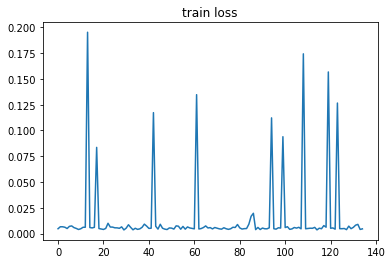

In [11]:
plt.plot(train_loss_history)
plt.title('train loss')
plt.show()

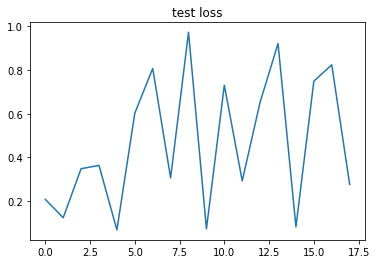

In [12]:
plt.plot(test_loss_history)
plt.title('test loss')
plt.show()

### Валидация модели

In [13]:
total_valid_f1_score = 0
with torch.no_grad():
  for valid_features, valid_labels in valid_loader:
      current_batch_size = len(valid_labels)
      valid_labels = valid_labels.to(device=device).view(current_batch_size, 1)
      attention_mask = valid_features['attention_mask'].to(device)
      input_ids = valid_features['input_ids'].squeeze(1).to(device=device)

      output = model(input_ids, attention_mask)

      total_valid_f1_score += calculate_metric(output.round().int(), valid_labels)
print(f'f1_score на валидации: {total_valid_f1_score / len(valid_loader)}')

f1_score на валидации: 0.8866432706087046


### Сохраним модель

In [15]:
torch.save(model.state_dict(), 'model.pth')